# **(ADD HERE THE NOTEBOOK NAME)**

## Objectives

* Using data from Kaggle, answer Business Requirement 1.


## Inputs

Following sets:

* Train

* Validation

* Test



## Outputs

Creating:
* The shapes of images
* Images per label plotted according to their variability and mean
* Plots illustrating the differences between healthy and mildewed leaves






In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/project5/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
work_dir = os.getcwd()
work_dir

'/workspace/project5'

In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import itertools
import random
from tensorflow.keras.preprocessing import image

import seaborn as sns

sns.set_style("darkgrid")


2023-05-28 13:34:18.037041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
my_data_dir = 'inputs/datasets/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

'inputs/datasets/cherry-leaves'

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('There is a version is already available, please create a new version.')
  pass
else:
  os.makedirs(name=file_path)


There is a version is already available, please create a new version.


# Analyzing image data and visualizing it

- calculating and plotting the average width and height of images in each label directory.

Labels for images are ['healthy', 'powdery_mildew']


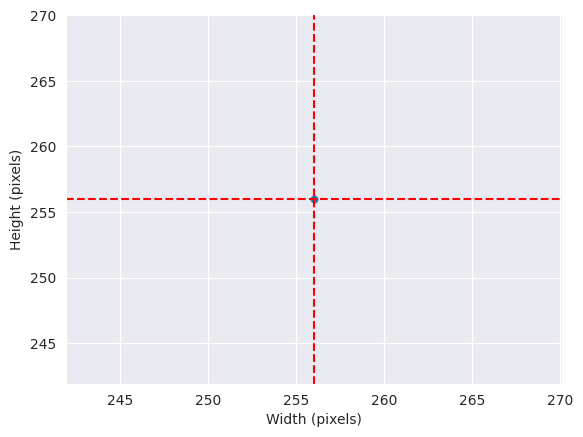

Average width: 256 
Average Height: 256


In [7]:



labels = os.listdir(train_path)
print('Labels for images are',labels)

dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
plt.axvline(x=dim1_mean,color='r', linestyle='--')
plt.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Average width: {dim2_mean} \nAverage Height: {dim1_mean}")


- save the shape of an image (64x64 with 3 channels) as a binary file using the joblib library.

In [8]:
images_shapes = (64,64,3)
joblib.dump(value=images_shapes ,
            filename=f"{file_path}/images_shapes.pkl")

['outputs/v2/images_shapes.pkl']

- Define a function called "generate_image_arrays_with_labels" which loads images from a directory, resizes them, and stores them in a numpy array along with their respective labels.


In [9]:

def generate_image_arrays_with_labels(my_data_dir, new_size=(50,50), max_images_per_label = 10):
      
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      if counter < max_images_per_label:
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y
  
X, y = generate_image_arrays_with_labels(my_data_dir=train_path,
                           new_size=images_shapes,
                           max_images_per_label=10)
print(X.shape, y.shape)




(20, 64, 64, 3) (20,)


- Define a function visualize_label_variability that will take in an array of images X and their labels y, and generate plots showing the average image and variability image (standard deviation) for each unique label in the dataset, and can optionally save the resulting plots as images.

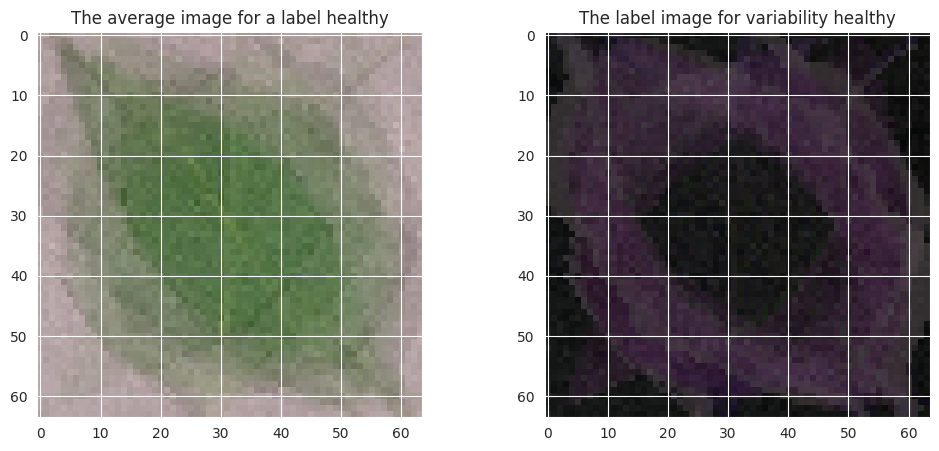

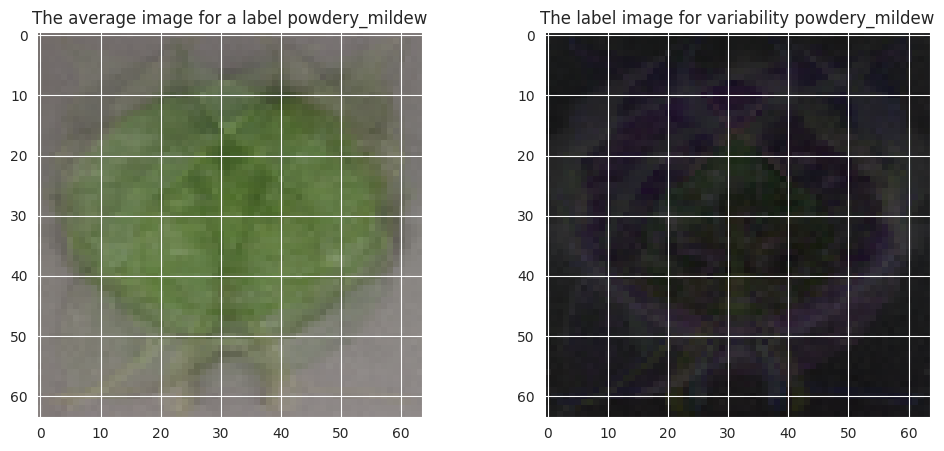

In [10]:


def visualize_label_variability(X, y, figsize=(12,5), save_image=False):
  for label in np.unique(y):
    mask = y == label
    arr = X[mask]
    avg_img, std_img = np.mean(arr, axis=0), np.std(arr, axis=0)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].set_title(f"The average image for a label {label}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"The label image for variability {label}")
    axes[1].imshow(std_img, cmap='gray')
    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()

visualize_label_variability(X, y, (12, 5), True)


- Define two functions: get_images_by_label, which generates a subset of images according to a given label, and plot_label_differences, which calculates and plots the difference between the average images of two different labels. The function also saves the resulting plot if the save_image parameter is set to True.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


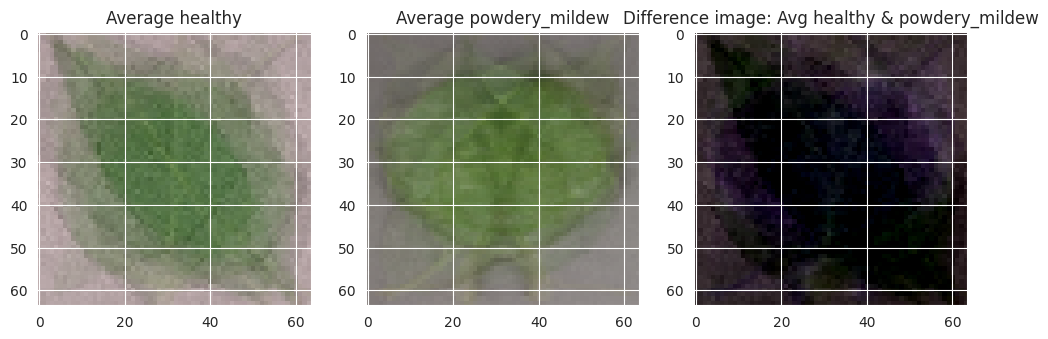

In [11]:


def get_images_by_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  return X[boolean_mask]


def plot_label_differences(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  sns.set_style("darkgrid")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"One or both of the labels {label} and {label_2} are not in the set of unique labels: {np.unique(y)}.")
    return

  label1_avg = np.mean(get_images_by_label(X, y, label_1), axis = 0)
  label2_avg = np.mean(get_images_by_label(X, y, label_2), axis = 0)

  Mean_of_difference = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(Mean_of_difference, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')

  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()


plot_label_differences(X=X,
                        y=y,
                        label_1='healthy',
                        label_2='powdery_mildew',
                        figsize=(12,10),
                        save_image=True
                        )




## Generating an Image Grid

Creating a grid of images from a directory of images with the specified number of rows and columns, with each image labeled.

healthy


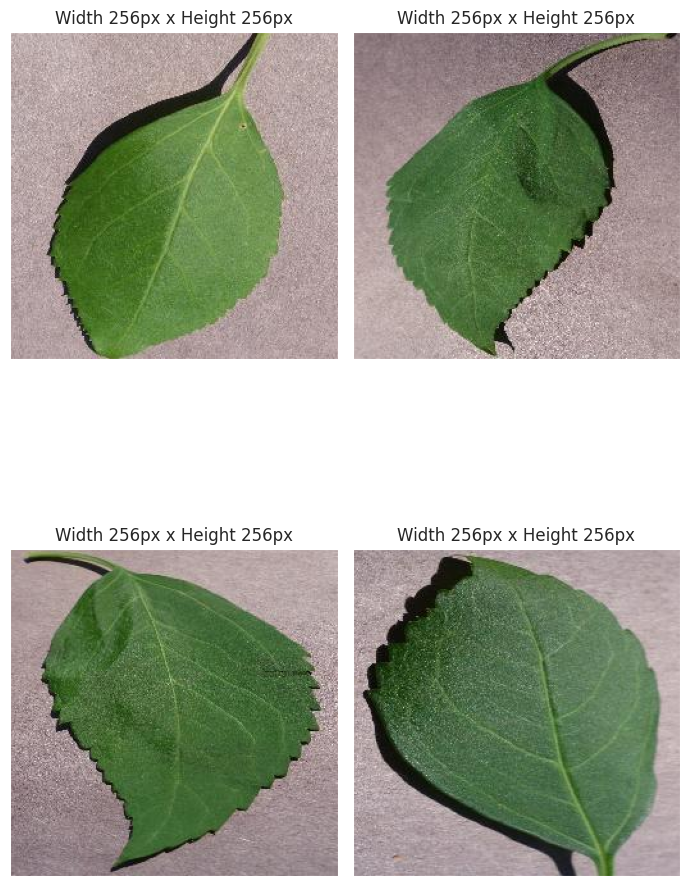



powdery_mildew


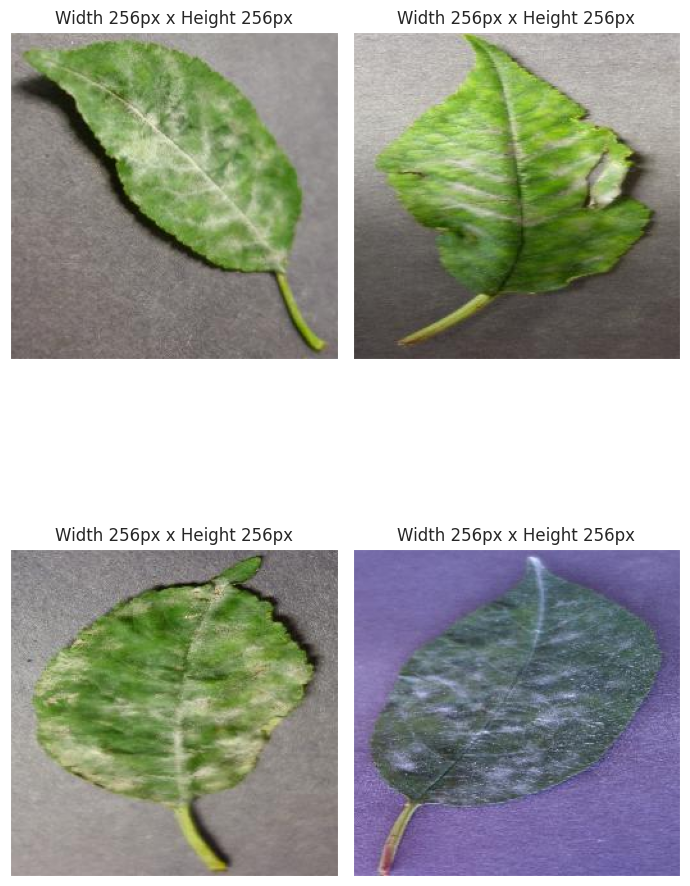

In [12]:


def image_grid(dir_path, available_labels, nrows=2, ncols=2, figsize=(7, 10)):


  labels = os.listdir(dir_path)

  if available_labels not in labels:
    print("This label doesn't exist.")
    print(f"The available labels include: {labels}")
    return

  images_list = os.listdir(dir_path + '/' + available_labels)

  if nrows * ncols > len(images_list):
    print(
        f"Not enough images to create a montage with the specified dimensions. Decrease the number of rows (nrows) or columns (ncols) \n"
        f"There are {len(images_list)} Available. "
        f"Returning image grid {nrows * ncols} spaces")
    return

  random_image_selection = random.sample(images_list, nrows * ncols)

  list_rows = range(0, nrows)
  list_cols = range(0, ncols)
  grid_indices = list(itertools.product(list_rows, list_cols))

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  for x in range(0, nrows*ncols):
    img = imread(dir_path + '/' + available_labels + '/' + random_image_selection[x])
    image_size = img.shape
    axes[grid_indices[x][0], grid_indices[x][1]].imshow(img)
    axes[grid_indices[x][0], grid_indices[x][1]].set_title(
        f"Width {image_size[1]}px x Height {image_size[0]}px")
    axes[grid_indices[x][0], grid_indices[x][1]].set_xticks([])
    axes[grid_indices[x][0], grid_indices[x][1]].set_yticks([])
  plt.tight_layout()
  plt.show()


for current_label in labels:
  print(current_label)
  image_grid(dir_path=train_path,
              available_labels=current_label,
              nrows=2, ncols=2,
              figsize=(7, 12))
  print("\n")



# Summary of Data Visualsation

- The code starts by listing the labels present in the train_path directory and printing them.

- It then calculates the dimensions (height and width) of each image for each label, and creates lists dim1 and dim2 to store the respective dimensions. Has a limit set incase the number of images are too high for effeiciency.


- A scatter plot is created using dim2 as the x-axis and dim1 as the y-axis, visualizing the distribution of image dimensions.

- The average width (dim2_mean) and average height (dim1_mean) are calculated and printed.

- The image shape (64, 64, 3) is stored in a file called images_shapes.pkl using the joblib library.

- The generate_image_arrays_with_labels function is defined, which takes a directory, image size, and number of images per label as input and returns two arrays: X (images) and y (labels).

- The function visualize_label_variability is defined to plot the average and variability images for each label using the X and y arrays.

- The get_images_by_label function is defined to retrieve a subset of images from X based on a specified label.

- The plot_label_differences function is defined to calculate and plot the average difference image between two labels using the get_images_by_label function.

- Finally, the image_grid function is defined to display a grid of images for each label in the labels list using the dir_path, available_labels, nrows, ncols, and figsize - - - parameters. The function is called for each label in the labels list, and the resulting image grid is displayed.

### To fix:

- Spelling mistakes causing code to not run. e.g. searching for 'Healthy' label instead of 'healthy' label (caps)

- remove image_shape.pkl file